In [6]:
import math
import re
import sys
import numpy as np
import gensim.downloader as api
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
from nltk.corpus import wordnet
import matplotlib.pyplot as plt

# 1. Implementation of the retrofitting algorithm on a toy corpus

### 1.1 Generating a toy corpus of the same format as the real corpora

In [5]:
# load pre-trained Word2Vec model to generate the toy corpus
model = api.load('word2vec-google-news-300')

In [7]:
# Creating functions to generate a toy corpus in the same format as for the provided word embeddings
def convert_matrix_to_dict(wordVecMat, wordList):
    wordVecs = {}
    for i, word in enumerate(wordList):
        wordVecs[word] = wordVecMat[i]
    return wordVecs

def convert_dict_to_matrix(wordVecs):
    wordVecMat = np.stack(list(wordVecs.values()))
    return wordVecMat

def vectorize_list(corpus):
    corpus_vecs = [model[word] for word in corpus]
    return corpus_vecs

# Useful for the big corpus to retrive the word list from the keys
def get_embeddings_words(wordVecs):
    wordList = list(wordVecs.keys()) 
    return wordList

In [7]:
# Get the same input format as the real corpus, i.e a dictionnary having for keys the words and for values their corresponding embeddings
toy_corpus = ["cat", "tiger", "computer", "keyboard", "plane", "car", "doctor", "nurse", "love", "sex"]
toy_list_vecs = vectorize_list(toy_corpus)
toy_wordVecs = convert_matrix_to_dict(toy_list_vecs, toy_corpus)
toy_wordList = get_embeddings_words(toy_wordVecs) # Not necessary for the toy corpus as toy_wordList == toy_corpus but generated here for reproductibility reasons with the real corpus

 ### 1.2 Calculating the similarities between the words of the corpus before the retrofitting

In [8]:
def calculate_cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_product = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    similarity = dot_product / norm_product
    return similarity

def generate_cosine_similarity_matrix(dict_vecs): 
    num_vectors = len(dict_vecs)
    similarity_matrix = np.zeros((num_vectors, num_vectors))
    for i, word1 in enumerate(dict_vecs):
        for j, word2 in enumerate(dict_vecs):
            similarity_matrix[i, j] = calculate_cosine_similarity(dict_vecs[word1], dict_vecs[word2])
    return similarity_matrix

def print_vec_similarities(wordList, similarity_matrix):
    for word, vec in zip(wordList, similarity_matrix):
        print(f'Similarities with "{word}":')
        for i in range(len(vec)):
            similarity = vec[i]
            print(f'  - "{wordList[i]}": {similarity:.4f}')
        print()

def print_vec_difference(wordList, similarity_matrix1, similarity_matrix2):
    for i, word in enumerate(wordList):
        print(f"\nSimilarities with \"{word}\":")
        for j, neighbor in enumerate(wordList):
            similarity1 = similarity_matrix1[i, j]
            similarity2 = similarity_matrix2[i, j]
            difference = similarity2 - similarity1 
            print(f"  - \"{neighbor}\": {similarity1:.4f} -> {similarity2:.4f} (Update: {difference:.4f})")

In [9]:
# Generate a matrix of similarity between the word vectors of the corpus
toy_similarity_matrix = generate_cosine_similarity_matrix(toy_wordVecs)
# Check its shape and dimension
print(type(toy_similarity_matrix)) 
print(toy_similarity_matrix.shape)  
print(toy_similarity_matrix.ndim) 
print('')
print_vec_similarities(toy_wordList, toy_similarity_matrix)

<class 'numpy.ndarray'>
(10, 10)
2

Similarities with "cat":
  - "cat": 1.0000
  - "tiger": 0.5173
  - "computer": 0.1732
  - "keyboard": 0.1834
  - "plane": 0.1833
  - "car": 0.2153
  - "doctor": 0.1292
  - "nurse": 0.1594
  - "love": 0.1406
  - "sex": 0.1368

Similarities with "tiger":
  - "cat": 0.5173
  - "tiger": 1.0000
  - "computer": 0.0677
  - "keyboard": 0.0654
  - "plane": 0.1660
  - "car": 0.1672
  - "doctor": 0.0835
  - "nurse": 0.1111
  - "love": 0.0871
  - "sex": 0.2222

Similarities with "computer":
  - "cat": 0.1732
  - "tiger": 0.0677
  - "computer": 1.0000
  - "keyboard": 0.3964
  - "plane": 0.1909
  - "car": 0.2461
  - "doctor": 0.1628
  - "nurse": 0.2178
  - "love": 0.0573
  - "sex": 0.1853

Similarities with "keyboard":
  - "cat": 0.1834
  - "tiger": 0.0654
  - "computer": 0.3964
  - "keyboard": 1.0000
  - "plane": 0.1006
  - "car": 0.1498
  - "doctor": 0.0850
  - "nurse": 0.1220
  - "love": 0.1591
  - "sex": 0.0943

Similarities with "plane":
  - "cat": 0.1833
  -

### 1.3 Managing the words' neighbors

In [9]:
def get_wordnet_lexicon(target_words, relation_types):
    lexicon = {}
        
    for word in target_words:
        related_words = []
        word_synsets = wordnet.synsets(word)
        
        # Skip word if no synsets found
        if not word_synsets:
            continue

        for syn in word_synsets:
            for lemma in syn.lemmas():
                if lemma.name() != word:
                    if "synonyms" in relation_types:
                        related_words.append(lemma.name())
                    if "antonyms" in relation_types:
                        if syn.lemmas()[0].antonyms():
                            related_words.append(syn.lemmas()[0].antonyms()[0].name())
                    if "hyponyms" in relation_types:
                        for hypo in syn.hyponyms():
                            for lemma in hypo.lemmas():
                                related_words.append(lemma.name())
                    if "hypernyms" in relation_types:
                        for hyper in syn.hypernyms():
                            for lemma in hyper.lemmas():
                                related_words.append(lemma.name())
                    if "meronyms" in relation_types:
                        for part in syn.part_meronyms():
                            for lemma in part.lemmas():
                                related_words.append(lemma.name())
                    if "holonyms" in relation_types:
                        for whole in syn.part_holonyms():
                            for lemma in whole.lemmas():
                                related_words.append(lemma.name())
                    if "homonyms" in relation_types:
                        for lemma in syn.lemmas():
                            if lemma.name() != word:
                                homonyms = wordnet.lemmas(lemma.name())
                                for homonym in homonyms:
                                    related_words.append(homonym.name())
        lexicon[word] = related_words
    return lexicon

In [11]:
# Generate a matrix of embeddings from the values in the word vectors dictionary
toy_wordVecMat = convert_dict_to_matrix(toy_wordVecs)

# Checking its shape and dimension 
print(type(toy_wordVecMat)) 
print(toy_wordVecMat.shape)  
print(toy_wordVecMat.ndim) 

<class 'numpy.ndarray'>
(10, 300)
2


In [10]:
def create_neighbors_embedding_matrix(wordList, relation_type):
    # Retrieve synonyms for each word
    neighbors_dict = get_wordnet_lexicon(wordList, relation_type)
    
    # Compute average embedding
    average_embeddings = []
    for word in wordList:
        neighbors = neighbors_dict.get(word, [])
        embeddings = [
            model.get_vector(neighbor)
            for neighbor in neighbors
            if model.has_index_for(neighbor)
        ]
        if len(embeddings) > 0:
            average_embedding = np.sum(embeddings, axis=0) / len(embeddings)
        else:
            # Handle the case where a word has no embeddings for its synonyms
            average_embedding = np.zeros(model.vector_size) 
        average_embeddings.append(average_embedding)
    
    # Create the word embedding matrix
    neighbors_embedding_matrix = np.vstack(average_embeddings)
    return neighbors_embedding_matrix

In [13]:
# Generate the neighbor matrix for the words in the toy corpus
toy_neighbors_matrix = create_neighbors_embedding_matrix(toy_wordList, "synonyms")
# Check its shape and dimension (they should match those of the matrix of embeddings)
print(type(toy_neighbors_matrix)) 
print(toy_neighbors_matrix.shape) 
print(toy_neighbors_matrix.ndim) 

<class 'numpy.ndarray'>
(10, 300)
2


### 1.4 Retrofitting

In [11]:
def retrofitting_wordVecs(wordVecMat, neighbors_matrix, alpha, beta, nb_iter):
    # Create a deep copy of wordVecMat 
    newWordVecMat = np.copy(wordVecMat, order='K')
    
    for _ in range(nb_iter):
        # Create a mask to identify vectors with non-null neighbors
        non_null_mask = np.any(neighbors_matrix != 0, axis=1)
        
        # Update the word embeddings using retrofitting formula
        newWordVecMat[non_null_mask] = (alpha * newWordVecMat[non_null_mask] + beta * neighbors_matrix[non_null_mask]) / (alpha + beta)

        # Stoping criterion
        if np.linalg.norm(newWordVecMat - wordVecMat) < 1e-2:
            break 

    return newWordVecMat

In [92]:
# Retrofitting the toy word embeddings
toy_retrofitted_vecs = retrofitting_wordVecs(toy_wordVecMat, toy_neighbors_matrix, alpha=1, beta=1, nb_iter=10)
# Convert the matrix of retrofitted embeddings to a dictionary
toy_retrofitted_wordVecs = convert_matrix_to_dict(toy_retrofitted_vecs, toy_wordList)
# Generate the similarity matrix
toy_retrofitted_similarity_matrix = generate_cosine_similarity_matrix(toy_retrofitted_wordVecs)
print_vec_difference(toy_wordList, toy_similarity_matrix, toy_retrofitted_similarity_matrix)

NameError: name 'toy_wordVecMat' is not defined

In [30]:
def measure_embedding_updates(original_matrix, retrofitted_matrix):
    absolute_diff = np.abs(original_matrix - retrofitted_matrix)
    mean_absolute_diff = np.mean(absolute_diff)
    return mean_absolute_diff

### 1.5 Tuning the (hyper)parameters

In [28]:
def tune_params(wordVecMat, neighbors_matrix, val_start, val_end, interval, min_nb_iter, max_nb_iter):
    best_embed_update = 0
    best_params = {}
    iteration_count = 0

    alpha_values = np.arange(val_start, val_end, interval)
    beta_values = np.arange(val_start, val_end, interval)
    nb_iter_values = range(min_nb_iter, max_nb_iter)

    performance_scores = np.zeros((len(alpha_values), len(beta_values), len(nb_iter_values)))

    for alpha_index, alpha in enumerate(alpha_values):
        for beta_index, beta in enumerate(beta_values):
            for nb_iter_index, nb_iter in enumerate(nb_iter_values):
                retrofitted_vec = retrofitting_wordVecs(wordVecMat, neighbors_matrix, alpha, beta, nb_iter)
                embed_update = measure_embedding_updates(wordVecMat, retrofitted_vec)
                performance_scores[alpha_index, beta_index, nb_iter_index] = embed_update

                if embed_update > best_embed_update:
                    best_embed_update = embed_update
                    best_params = {'alpha': alpha, 'beta': beta, 'nb_iter': nb_iter}

                iteration_count += 1
                if iteration_count >= 100:
                    break
            if iteration_count >= 100:
                break
        if iteration_count >= 100:
            break

    print("Best hyperparameters:", best_params)
    print("Best embedding update:", best_embed_update)

    return performance_scores, alpha_values, beta_values, nb_iter_values, best_params["alpha"], best_params["beta"], best_params["nb_iter"]

In [18]:
toy_perf, toy_a_values, toy_b_vales, toy_it_values, toy_alpha, toy_beta, toy_nb_iter = tune_params(toy_wordVecMat, toy_neighbors_matrix, val_start=0.1, val_end=3.1, interval=0.5, min_nb_iter=1, max_nb_iter=16)

Best hyperparameters: {'alpha': 0.1, 'beta': 1.1, 'nb_iter': 15}
Best embedding update: 0.12671235242449622


In [19]:
# Retrofitting the original embeddings with the new (hyper)parameter values
toy_new_retrofitted_vec = retrofitting_wordVecs(toy_wordVecMat, toy_neighbors_matrix, toy_alpha, toy_beta, toy_nb_iter)
toy_new_retrofitted_dict = convert_matrix_to_dict(toy_new_retrofitted_vec, toy_wordList)
toy_new_retrofitted_similarity_matrix = generate_cosine_similarity_matrix(toy_new_retrofitted_dict)
print_vec_difference(toy_wordList, toy_similarity_matrix, toy_new_retrofitted_similarity_matrix)


Similarities with "cat":
  - "cat": 1.0000 -> 1.0000 (Update: 0.0000)
  - "tiger": 0.5173 -> 0.2020 (Update: -0.3153)
  - "computer": 0.1732 -> 0.1972 (Update: 0.0239)
  - "keyboard": 0.1834 -> 0.2055 (Update: 0.0220)
  - "plane": 0.1833 -> 0.3945 (Update: 0.2111)
  - "car": 0.2153 -> 0.2635 (Update: 0.0482)
  - "doctor": 0.1292 -> 0.3434 (Update: 0.2141)
  - "nurse": 0.1594 -> 0.5485 (Update: 0.3892)
  - "love": 0.1406 -> 0.5941 (Update: 0.4535)
  - "sex": 0.1368 -> 0.2599 (Update: 0.1231)

Similarities with "tiger":
  - "cat": 0.5173 -> 0.2020 (Update: -0.3153)
  - "tiger": 1.0000 -> 1.0000 (Update: 0.0000)
  - "computer": 0.0677 -> 0.0903 (Update: 0.0226)
  - "keyboard": 0.0654 -> 0.1831 (Update: 0.1177)
  - "plane": 0.1660 -> 0.0731 (Update: -0.0930)
  - "car": 0.1672 -> 0.1003 (Update: -0.0669)
  - "doctor": 0.0835 -> 0.0891 (Update: 0.0056)
  - "nurse": 0.1111 -> 0.2026 (Update: 0.0915)
  - "love": 0.0871 -> 0.1910 (Update: 0.1040)
  - "sex": 0.2222 -> 0.1881 (Update: -0.0341)



In [20]:
# Checking the difference between the first retrofitted similarity matrix and the one with the updated (hyper)parameter values
print_vec_difference(toy_wordList, toy_retrofitted_similarity_matrix, toy_new_retrofitted_similarity_matrix)


Similarities with "cat":
  - "cat": 1.0000 -> 1.0000 (Update: -0.0000)
  - "tiger": 0.2028 -> 0.2020 (Update: -0.0008)
  - "computer": 0.1974 -> 0.1972 (Update: -0.0002)
  - "keyboard": 0.2057 -> 0.2055 (Update: -0.0003)
  - "plane": 0.3947 -> 0.3945 (Update: -0.0002)
  - "car": 0.2636 -> 0.2635 (Update: -0.0001)
  - "doctor": 0.3436 -> 0.3434 (Update: -0.0002)
  - "nurse": 0.5487 -> 0.5485 (Update: -0.0001)
  - "love": 0.5941 -> 0.5941 (Update: -0.0001)
  - "sex": 0.2601 -> 0.2599 (Update: -0.0002)

Similarities with "tiger":
  - "cat": 0.2028 -> 0.2020 (Update: -0.0008)
  - "tiger": 1.0000 -> 1.0000 (Update: -0.0000)
  - "computer": 0.0903 -> 0.0903 (Update: 0.0000)
  - "keyboard": 0.1831 -> 0.1831 (Update: 0.0001)
  - "plane": 0.0734 -> 0.0731 (Update: -0.0004)
  - "car": 0.1005 -> 0.1003 (Update: -0.0001)
  - "doctor": 0.0891 -> 0.0891 (Update: -0.0000)
  - "nurse": 0.2028 -> 0.2026 (Update: -0.0002)
  - "love": 0.1912 -> 0.1910 (Update: -0.0002)
  - "sex": 0.1883 -> 0.1881 (Updat

# 2. Retrofitting the English gensim corpus

### 2.1 Retrieving the word vectors from the gensim file and the lexicon from the ws353 file

In [18]:
# These functions are copied from https://github.com/mfaruqui/retrofitting and have only been slightly altered
isNumber = re.compile(r'\d+.*')

def norm_word(word):
  """
  - input: word
  - return: a normalized version of it
  Normalization process: includes checking if the word is a number or a punctuation mark and replacing it with special tokens
  """
  if isNumber.search(word.lower()):
    return '---num---'
  # check if the word consists only of non-alphanumeric characters by removing all non-alphanumeric characters from the word 
  # and checking if the result is an empty string
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
  # if input word not a number nor a punctuation mark, return a lowercase version of input word
    return word.lower()
  
''' Read all the word vectors and normalize them '''
def read_word_vecs(filename):
  """
  - input: name of the file containing the word vectors
  """
  wordVectors = {}
  with open(filename, 'r', encoding='utf-8') as fileObject:
    first_line = True
    for line in fileObject:
      line = line.strip().lower()
      # Skip the first line
      if first_line:
        first_line =False
        continue
      # The first word is assumed to be the word itself, and the remaining words are assumed to be the components of the word vector
      word = line.split()[0]
      # initialize a numpy array of zeros with the same length as the word vector
      wordVectors[word] = np.zeros(len(line.split())-1, dtype=float)
      for index, vecVal in enumerate(line.split()[1:]):
        # assign the values in the numpy array to the corresponding components of the word vector
        wordVectors[word][index] = float(vecVal)
      ''' normalize weight vector '''
      # divide each element by the square root of the sum of the squares of all the elements in the array
      # plus a small constant (1e-6) to avoid division by zero
      wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)
  
  # standard error indicating that the vectors have been read from the file 
  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

''' Read the PPDB word relations as a dictionary '''
def read_lexicon(filename):
    lexicon = {}
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            words = line.lower().strip().split()
            lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]

''' Write word vectors to file '''
def print_word_vecs(wordVectors, outFileName):
  """
  - input: a dictionary wordVectors where keys are words and values are their corresponding word vectors
           file name outFileName
  """
  sys.stderr.write('\nWriting down the vectors in '+outFileName+'\n')
  outFile = open(outFileName, 'w', encoding= 'utf-8')  
  for word, values in wordVectors.items():
    outFile.write(word+' ')
    for val in wordVectors[word]:
      outFile.write('%.8f' %(val)+' ')
    outFile.write('\n')      
  outFile.close()

In [56]:
# Retrieving the word vectors in a dictionary (key: word, value: embedding)
EN_wordVecs = read_word_vecs("../data/English/wordEmbeddings/vectors_datatxt_250_sg_w10_i5_c500_gensim_clean")
# Retrieving the pairs of words with human scores
EN_lexical_similarity = read_lexicon("../data/English/lexicon/ws353_lexical_similarity.txt")
# Creating an output file to print back the updated embeddings
EN_output_file = "../data/English/output_vectors/output_vectors.txt"

Vectors read from: ../data/English/wordEmbeddings/vectors_datatxt_250_sg_w10_i5_c500_gensim_clean 


In [57]:
# Retrieving the necessary objects for the retrofitting
EN_wordList = get_embeddings_words(EN_wordVecs)
EN_neighbors_dict = get_wordnet_lexicon(EN_wordList, "synonyms") 
EN_wordVecMat = convert_dict_to_matrix(EN_wordVecs)

### 2.2 Calculating the similarities before retrofitting the embeddings

In [16]:
# Check the similarity between the word vectors of the corpus 
# (only considering the words in the lexicon similarity file)

def print_lexical_similarities(wordVecs, lines, lang):
    # Create a list to store the words
    word_list = []

    # Iterate over the lines and extract the words
    for line in lines:
        if lang == 'en':
            words = line.strip().split('\t')
        else:
            words = line.strip().split()
        word_list.append((words[0], words[1]))  # Store the words as a tuple

    # Determine the subset of words present in the wordVecs file while preserving the order
    subset = [word for word in word_list if word[0] in wordVecs and word[1] in wordVecs]

    # Create an empty list to store the similarities
    similarities = []

    # Iterate over each tuple in the subset
    for word1, word2 in subset:
        if word1 in wordVecs and word2 in wordVecs:
            # Calculate the similarity between the embeddings
            similarity_score = cosine_similarity([wordVecs[word1]], [wordVecs[word2]])

            # Append the similarity value to the list of similarities
            similarities.append(similarity_score)

    # Print the similarities
    for i, similarity_score in enumerate(similarities):
        print(f"Similarity between '{subset[i][0]}' and '{subset[i][1]}': {similarity_score[0][0]}")

def print_similarity_difference(wordVecs1, wordVecs2, lines, lang):
    # Create a list to store the words
    word_list = []

    # Iterate over the lines and extract the words
    for line in lines:
        if lang == 'en':
            words = line.strip().split('\t')
        else:
            words = line.strip().split()
        word_list.append((words[0], words[1]))  # Store the words as a tuple

    # Determine the subset of words present in both wordVecs1 and wordVecs2 while preserving the order
    subset = [word for word in word_list if word[0] in wordVecs1 and word[1] in wordVecs2]

    # Create an empty list to store the similarity scores
    similarities1 = []
    similarities2 = []

    # Iterate over each tuple in the subset
    for word1, word2 in subset:
        # Calculate the similarity between the embeddings in wordVecs1
        similarity_score1 = cosine_similarity([wordVecs1[word1]], [wordVecs1[word2]])

        # Calculate the similarity between the embeddings in wordVecs2
        similarity_score2 = cosine_similarity([wordVecs2[word1]], [wordVecs2[word2]])

        # Append the similarity scores to the respective lists
        similarities1.append(similarity_score1[0][0])
        similarities2.append(similarity_score2[0][0])

    # Print the similarities and their difference
    for i, (word1, word2) in enumerate(subset):
        difference = similarities1[i] - similarities2[i]
        if difference != 0.0:        
            print(f"Similarity between '{word1}' and '{word2}' before retrofitting: {similarities1[i]}")
            print(f"Similarity between '{word1}' and '{word2}' after retrofitting: {similarities2[i]}")
            print(f"Update: {difference}\n")

In [59]:
# Retrive word pairs from the lexical similarity file
with open('../data/English/lexicon/ws353_lexical_similarity.txt', 'r') as file:
    EN_lines = file.readlines()
# Get their similarities
print_lexical_similarities(EN_wordVecs, EN_lines, "en")

Similarity between 'love' and 'sex': 0.3213976283166737
Similarity between 'tiger' and 'cat': 0.4484269447717373
Similarity between 'tiger' and 'tiger': 1.0
Similarity between 'book' and 'paper': 0.5720403096134581
Similarity between 'computer' and 'keyboard': 0.4902811841797181
Similarity between 'computer' and 'internet': 0.49881600720718505
Similarity between 'plane' and 'car': 0.4094837589536879
Similarity between 'train' and 'car': 0.5024532628135742
Similarity between 'telephone' and 'communication': 0.36768667290283835
Similarity between 'television' and 'radio': 0.6536351915117727
Similarity between 'media' and 'radio': 0.3209847572779895
Similarity between 'drug' and 'abuse': 0.42865908078081993
Similarity between 'bread' and 'butter': 0.8071053286387004
Similarity between 'cucumber' and 'potato': 0.6915610413305441
Similarity between 'doctor' and 'nurse': 0.5676552249319599
Similarity between 'professor' and 'doctor': 0.5076438957646101
Similarity between 'student' and 'profe

### 2.3 Generating a matrix of neighbors' embeddings

In [15]:
# Generating the matrix of neighbor's embeddings has been updated to retrieve the embeddings from the matrix of embeddings to update rather than from word2vec
def retrieve_neighbors_embedding_matrix(wordVecMat, wordList, neighbors_dict):
    valid_neighbors = set(neighbor for neighbors in neighbors_dict.values() for neighbor in neighbors) & set(wordList)

    embedding_size = wordVecMat.shape[1]
    average_embeddings = []

    for word in wordList:
        neighbors = neighbors_dict.get(word, [])
        if neighbors and any(neighbor in valid_neighbors for neighbor in neighbors):
            embeddings = np.array([
                wordVecMat[wordList.index(neighbor)] if neighbor in wordList else np.zeros(embedding_size)
                for neighbor in neighbors
                if neighbor in valid_neighbors
            ])
            if embeddings.size > 0:
                average_embedding = np.mean(embeddings, axis=0)
                average_embeddings.append(average_embedding)
        else:
            average_embeddings.append(np.zeros(embedding_size))

    neighbors_embedding_matrix = np.vstack(average_embeddings)
    return neighbors_embedding_matrix

In [61]:
# Generate the matrix of neighbor's embeddings
EN_neighbors_matrix = retrieve_neighbors_embedding_matrix(EN_wordVecMat, EN_wordList, EN_neighbors_dict)

In [62]:
# Visualizing the matrix of neighbor's embedding on a subset
EN_subset_wordVecs = {word: EN_wordVecs[word] for word in EN_wordList[:100]}
EN_subset_neighbors_dict = {word: EN_neighbors_dict[word] for word in list(EN_neighbors_dict.keys())[:100]}
EN_subset_wordVecMat = EN_wordVecMat[:100] 
EN_subset_wordList = EN_wordList[:100]

# Test the function on the subset
EN_subset_neighbors_matrix = retrieve_neighbors_embedding_matrix(EN_subset_wordVecMat, EN_subset_wordList, EN_subset_neighbors_dict)

# Print the result
print(EN_subset_neighbors_matrix)
print(type(EN_subset_neighbors_matrix))  
print(EN_subset_neighbors_matrix.shape)  
print(EN_subset_neighbors_matrix.ndim) 

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.07520224 0.07037208 0.0224631  ... 0.03620975 0.02141031 0.15191107]
 [0.         0.         0.         ... 0.         0.         0.        ]]
<class 'numpy.ndarray'>
(100, 250)
2


### 2.4 Retrofitting 

In [63]:
# Checking that the matrices we pass as argument of the retrofitting algorithm have the same shape and dimension
print("Matrix of word embeddings")
print(type(EN_neighbors_matrix))  
print(EN_neighbors_matrix.shape)  
print(EN_neighbors_matrix.ndim) 
print("\nMatrix of neighbors' embeddings")
print(type(EN_wordVecMat))  
print(EN_wordVecMat.shape)  
print(EN_wordVecMat.ndim) 

Matrix of word embeddings
<class 'numpy.ndarray'>
(125776, 250)
2

Matrix of neighbors' embeddings
<class 'numpy.ndarray'>
(125776, 250)
2


In [64]:
# Retrofitting the English word embeddings
EN_retrofitted_vecs = retrofitting_wordVecs(EN_wordVecMat, EN_neighbors_matrix, alpha=1, beta=1, nb_iter=10)

In [14]:
# Retrieve similarity scores before and after retrofitting
def get_similarity_difference(wordVecs1, wordVecs2, lines, lang):
    # Create a list to store the words
    word_list = []

    # Iterate over the lines and extract the words
    for line in lines:
        if lang == 'en':
            words = line.strip().split('\t')
        else:
            words = line.strip().split()
        word_list.append((words[0], words[1]))  # Store the words as a tuple

    # Determine the subset of words present in both wordVecs1 and wordVecs2 while preserving the order
    subset = [word for word in word_list if word[0] in wordVecs1 and word[1] in wordVecs2]

    # Create an empty list to store the similarity scores
    similarities1 = []
    similarities2 = []

    # Iterate over each tuple in the subset
    for word1, word2 in subset:
        # Calculate the similarity between the embeddings in wordVecs1
        similarity_score1 = cosine_similarity([wordVecs1[word1]], [wordVecs1[word2]])

        # Calculate the similarity between the embeddings in wordVecs2
        similarity_score2 = cosine_similarity([wordVecs2[word1]], [wordVecs2[word2]])

        # Append the similarity scores to the respective lists
        similarities1.append(similarity_score1[0][0])
        similarities2.append(similarity_score2[0][0])

    # Create a list to store the similarity differences
    differences = []

    # Iterate over each word pair in the subset
    for i, (word1, word2) in enumerate(subset):
        difference = similarities1[i] - similarities2[i]
        if difference != 0.0:
            differences.append((word1, word2, similarities1[i], similarities2[i], difference))

    # Return the similarity differences
    return differences

In [66]:
# Calculate the similarities between word embedding pairs after the retrofitting
EN_retrofitted_wordVecs = convert_matrix_to_dict(EN_retrofitted_vecs, EN_wordList)
EN_diff_sy = get_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs, EN_lines, "en")
print_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs, EN_lines, "en")

Similarity between 'love' and 'sex' before retrofitting: 0.3213976283166737
Similarity between 'love' and 'sex' after retrofitting: 0.47673179076915473
Update: -0.15533416245248105

Similarity between 'tiger' and 'cat' before retrofitting: 0.4484269447717373
Similarity between 'tiger' and 'cat' after retrofitting: 0.37263892654144615
Update: 0.07578801823029113

Similarity between 'book' and 'paper' before retrofitting: 0.5720403096134581
Similarity between 'book' and 'paper' after retrofitting: 0.6017146691372111
Update: -0.02967435952375297

Similarity between 'computer' and 'keyboard' before retrofitting: 0.4902811841797181
Similarity between 'computer' and 'keyboard' after retrofitting: 0.34049956739588355
Update: 0.14978161678383456

Similarity between 'computer' and 'internet' before retrofitting: 0.49881600720718505
Similarity between 'computer' and 'internet' after retrofitting: 0.27021129120136117
Update: 0.22860471600582388

Similarity between 'plane' and 'car' before retrofi

### 2.5 Tuning the (hyper)parameters

In [67]:
# Tuning the (hyper)parameters
EN_perf, EN_a_values, EN_b_values, EN_it_values, EN_alpha, EN_beta, EN_nb_iter = tune_params(EN_wordVecMat, EN_neighbors_matrix, val_start=0.1, val_end=3.1, interval=1, min_nb_iter=1, max_nb_iter=6)

Best hyperparameters: {'alpha': 0.1, 'beta': 2.1, 'nb_iter': 5}
Best embedding update: 0.048375377899576244


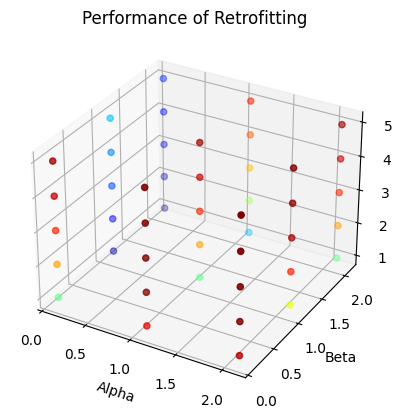

In [68]:
# Create a meshgrid for the hyperparameter values
EN_alpha_mesh, EN_beta_mesh, EN_nb_iter_mesh = np.meshgrid(EN_a_values, EN_b_values, EN_it_values)

# Plot the performances
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(EN_alpha_mesh, EN_beta_mesh, EN_nb_iter_mesh, c=EN_perf.flatten(), cmap='jet')
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Number of Iterations')
ax.set_title('Performance of Retrofitting')
plt.show()

In [96]:
# Retrofitting the original embeddings with the new (hyper)parameter values
EN_new_retrofitted_vec = retrofitting_wordVecs(EN_wordVecMat, EN_neighbors_matrix, EN_alpha, EN_beta, EN_nb_iter)
EN_new_retrofitted_dict = convert_matrix_to_dict(EN_new_retrofitted_vec, EN_wordList)
print_similarity_difference(EN_wordVecs, EN_new_retrofitted_dict, EN_lines, "en")

Similarity between 'love' and 'sex' before retrofitting: 0.3213976283166737
Similarity between 'love' and 'sex' after retrofitting: 0.47643997518879716
Update: -0.15504234687212348

Similarity between 'tiger' and 'cat' before retrofitting: 0.4484269447717373
Similarity between 'tiger' and 'cat' after retrofitting: 0.3721418119120699
Update: 0.07628513285966737

Similarity between 'book' and 'paper' before retrofitting: 0.5720403096134581
Similarity between 'book' and 'paper' after retrofitting: 0.6010852121085877
Update: -0.029044902495129588

Similarity between 'computer' and 'keyboard' before retrofitting: 0.4902811841797181
Similarity between 'computer' and 'keyboard' after retrofitting: 0.3401041354897838
Update: 0.1501770486899343

Similarity between 'computer' and 'internet' before retrofitting: 0.49881600720718505
Similarity between 'computer' and 'internet' after retrofitting: 0.26977087270454997
Update: 0.22904513450263508

Similarity between 'plane' and 'car' before retrofitt

### 2.6 Testing the performances depending on the type of semantic relation

In [70]:
# Trying with antonyms
EN_neighbors_dict_an = get_wordnet_lexicon(EN_wordList, "antonyms")
# Generate the matrix of neighbor's embeddings
EN_neighbors_matrix_an = retrieve_neighbors_embedding_matrix(EN_wordVecMat, EN_wordList, EN_neighbors_dict_an)
# Retrofitting the English word embeddings
EN_retrofitted_vecs_an = retrofitting_wordVecs(EN_wordVecMat, EN_neighbors_matrix_an, EN_alpha, EN_beta, EN_nb_iter)
# Calculate the similarities between word embedding pairs after the retrofitting
EN_retrofitted_wordVecs_an = convert_matrix_to_dict(EN_retrofitted_vecs_an, EN_wordList)
EN_diff_an = get_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs_an, EN_lines, "en")
print_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs_an, EN_lines, "en")

Similarity between 'tiger' and 'cat' before retrofitting: 0.4484269447717373
Similarity between 'tiger' and 'cat' after retrofitting: 0.4484269447717372
Update: 5.551115123125783e-17

Similarity between 'computer' and 'internet' before retrofitting: 0.49881600720718505
Similarity between 'computer' and 'internet' after retrofitting: 0.498816007207185
Update: 5.551115123125783e-17

Similarity between 'plane' and 'car' before retrofitting: 0.4094837589536879
Similarity between 'plane' and 'car' after retrofitting: 0.4094837589536878
Update: 5.551115123125783e-17

Similarity between 'train' and 'car' before retrofitting: 0.5024532628135742
Similarity between 'train' and 'car' after retrofitting: 0.502453262813574
Update: 1.1102230246251565e-16

Similarity between 'telephone' and 'communication' before retrofitting: 0.36768667290283835
Similarity between 'telephone' and 'communication' after retrofitting: 0.3676866729028382
Update: 1.6653345369377348e-16

Similarity between 'television' an

In [71]:
# Trying with hyponyms: NOT taken into account because it is way too big
# EN_neighbors_dict_hy = get_wordnet_lexicon(EN_wordList, "hyponyms") 
# # Generate the matrix of neighbor's embeddings
# EN_neighbors_matrix_hy  = retrieve_neighbors_embedding_matrix(EN_wordVecMat, EN_wordList, EN_neighbors_dict_hy )
# # Retrofitting the English word embeddings
# EN_retrofitted_vecs_hy  = retrofitting_wordVecs(EN_wordVecMat, EN_neighbors_matrix_hy , EN_alpha, EN_beta, EN_nb_iter)
# # Calculate the similarities between word embedding pairs after the retrofitting
# EN_retrofitted_wordVecs_hy  = convert_matrix_to_dict(EN_retrofitted_vecs_hy , EN_wordList)
# print_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs_hy , EN_lines, "en")

In [98]:
# Trying with hypernyms
EN_neighbors_dict_her = get_wordnet_lexicon(EN_wordList, "hypernyms") 
# Generate the matrix of neighbor's embeddings
EN_neighbors_matrix_her  = retrieve_neighbors_embedding_matrix(EN_wordVecMat, EN_wordList, EN_neighbors_dict_her )
# Retrofitting the English word embeddings
EN_retrofitted_vecs_her  = retrofitting_wordVecs(EN_wordVecMat, EN_neighbors_matrix_her, EN_alpha, EN_beta, EN_nb_iter)
# Calculate the similarities between word embedding pairs after the retrofitting
EN_retrofitted_wordVecs_her  = convert_matrix_to_dict(EN_retrofitted_vecs_her, EN_wordList)
EN_diff_her = get_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs_her, EN_lines, "en")
print_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs_her, EN_lines, "en")

Similarity between 'love' and 'sex' before retrofitting: 0.3213976283166737
Similarity between 'love' and 'sex' after retrofitting: 0.3834303293395825
Update: -0.06203270102290881

Similarity between 'tiger' and 'cat' before retrofitting: 0.4484269447717373
Similarity between 'tiger' and 'cat' after retrofitting: 0.3222583906721179
Update: 0.12616855409961936

Similarity between 'book' and 'paper' before retrofitting: 0.5720403096134581
Similarity between 'book' and 'paper' after retrofitting: 0.6554933942115123
Update: -0.08345308459805423

Similarity between 'computer' and 'keyboard' before retrofitting: 0.4902811841797181
Similarity between 'computer' and 'keyboard' after retrofitting: 0.30979534595351366
Update: 0.18048583822620445

Similarity between 'computer' and 'internet' before retrofitting: 0.49881600720718505
Similarity between 'computer' and 'internet' after retrofitting: 0.3432160896510521
Update: 0.15559991755613295

Similarity between 'plane' and 'car' before retrofitti

In [73]:
# Trying with meronyms
EN_neighbors_dict_me = get_wordnet_lexicon(EN_wordList, "meronyms") 
# Generate the matrix of neighbor's embeddings
EN_neighbors_matrix_me  = retrieve_neighbors_embedding_matrix(EN_wordVecMat, EN_wordList, EN_neighbors_dict_me)
# Retrofitting the English word embeddings
EN_retrofitted_vecs_me  = retrofitting_wordVecs(EN_wordVecMat, EN_neighbors_matrix_me, EN_alpha, EN_beta, EN_nb_iter)
# Calculate the similarities between word embedding pairs after the retrofitting
EN_retrofitted_wordVecs_me  = convert_matrix_to_dict(EN_retrofitted_vecs_me, EN_wordList)
EN_diff_me = get_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs_me, EN_lines, "en")
print_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs_me, EN_lines, "en")

Similarity between 'tiger' and 'cat' before retrofitting: 0.4484269447717373
Similarity between 'tiger' and 'cat' after retrofitting: 0.4484269447717372
Update: 5.551115123125783e-17

Similarity between 'book' and 'paper' before retrofitting: 0.5720403096134581
Similarity between 'book' and 'paper' after retrofitting: 0.4293998153420031
Update: 0.14264049427145498

Similarity between 'computer' and 'keyboard' before retrofitting: 0.4902811841797181
Similarity between 'computer' and 'keyboard' after retrofitting: 0.6022095155126571
Update: -0.111928331332939

Similarity between 'computer' and 'internet' before retrofitting: 0.49881600720718505
Similarity between 'computer' and 'internet' after retrofitting: 0.4438859400886296
Update: 0.05493006711855547

Similarity between 'plane' and 'car' before retrofitting: 0.4094837589536879
Similarity between 'plane' and 'car' after retrofitting: 0.9038868252303931
Update: -0.4944030662767052

Similarity between 'train' and 'car' before retrofitti

In [74]:
# Trying with holonyms
EN_neighbors_dict_ho = get_wordnet_lexicon(EN_wordList, "holonyms") 
# Generate the matrix of neighbor's embeddings
EN_neighbors_matrix_ho  = retrieve_neighbors_embedding_matrix(EN_wordVecMat, EN_wordList, EN_neighbors_dict_ho)
# Retrofitting the English word embeddings
EN_retrofitted_vecs_ho  = retrofitting_wordVecs(EN_wordVecMat, EN_neighbors_matrix_ho, EN_alpha, EN_beta, EN_nb_iter)
# Calculate the similarities between word embedding pairs after the retrofitting
EN_retrofitted_wordVecs_ho  = convert_matrix_to_dict(EN_retrofitted_vecs_ho, EN_wordList)
EN_diff_ho = get_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs_ho, EN_lines, "en")
print_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs_ho, EN_lines, "en")

Similarity between 'tiger' and 'cat' before retrofitting: 0.4484269447717373
Similarity between 'tiger' and 'cat' after retrofitting: 0.4484269447717372
Update: 5.551115123125783e-17

Similarity between 'computer' and 'keyboard' before retrofitting: 0.4902811841797181
Similarity between 'computer' and 'keyboard' after retrofitting: 0.1564067598098203
Update: 0.3338744243698978

Similarity between 'computer' and 'internet' before retrofitting: 0.49881600720718505
Similarity between 'computer' and 'internet' after retrofitting: 0.37759697093050393
Update: 0.12121903627668112

Similarity between 'plane' and 'car' before retrofitting: 0.4094837589536879
Similarity between 'plane' and 'car' after retrofitting: 0.5679163987100576
Update: -0.15843263975636973

Similarity between 'train' and 'car' before retrofitting: 0.5024532628135742
Similarity between 'train' and 'car' after retrofitting: 0.5160300258779644
Update: -0.013576763064390263

Similarity between 'telephone' and 'communication' b

In [75]:
# Trying with homonyms: NOT taken into account because it is way too big
# EN_neighbors_dict_hom = get_wordnet_lexicon(EN_wordList, "homonyms") 
# # Generate the matrix of neighbor's embeddings
# EN_neighbors_matrix_hom  = retrieve_neighbors_embedding_matrix(EN_wordVecMat, EN_wordList, EN_neighbors_dict_hom)
# # Retrofitting the English word embeddings
# EN_retrofitted_vecs_hom  = retrofitting_wordVecs(EN_wordVecMat, EN_neighbors_matrix_hom, EN_alpha, EN_beta, EN_nb_iter)
# # Calculate the similarities between word embedding pairs after the retrofitting
# EN_retrofitted_wordVecs_hom  = convert_matrix_to_dict(EN_retrofitted_vecs_hom, EN_wordList)
# print_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs_hom, EN_lines, "en")

In [40]:
# Checking the best relation types for acknowledgeable retrofitting performance
def get_relation_type_spearman_score(relation_types_perf):
    correlation_scores = {}

    for relation_type, similarity_scores in relation_types_perf.items():
        similarity_scores_before = []
        similarity_scores_after = []

        for word_pair in similarity_scores:
            similarity_before = word_pair[2]
            similarity_after = word_pair[3]

            similarity_scores_before.append(similarity_before)
            similarity_scores_after.append(similarity_after)

        correlation, _ = spearmanr(similarity_scores_before, similarity_scores_after)
        correlation_scores[relation_type] = correlation
    return correlation_scores

In [77]:
EN_relation_types_perf = {"synonyms": EN_diff_sy, "antonyms": EN_diff_an, "hypernyms": EN_diff_her, "meronyms": EN_diff_me} #"holonyms": EN_diff_ho
EN_correlation_scores = get_relation_type_spearman_score(EN_relation_types_perf)
print("Correlation Scores:")
for relation_type, correlation in EN_correlation_scores.items():
    print(f"{relation_type}: {correlation}")

Correlation Scores:
synonyms: 0.3485108175772522
antonyms: 0.860159421890017
hypernyms: 0.22109019767817825
meronyms: 0.7723997096478554


In [78]:
# Retrieve the appropriate matrices of neighbor embeddings based on Spearman score threshold
def create_combined_neighbors_matrix(neighbors_matrices, correlation_scores):
    selected_relation_types = [relation_type for relation_type, correlation in correlation_scores.items() if correlation < 0.3]
    relation_types_embeddings = {relation_type: neighbors_matrices[relation_type] for relation_type in selected_relation_types}
    # Initialize the final combined matrix
    combined_matrix = np.zeros_like(list(relation_types_embeddings.values())[0])

    # Iterate over each row of the matrices for the selected relation types
    for row_idx in range(combined_matrix.shape[0]):
        # Initialize a list to store the row elements for averaging
        row_elements = []
        
        # Iterate over each matrix of embeddings for the selected relation types
        for relation_type, embeddings_matrix in relation_types_embeddings.items():
            # Append the element at the current row and column index to the list
            row_elements.append(embeddings_matrix[row_idx])
        
        # Calculate the average of the row elements
        averaged_row = np.mean(row_elements, axis=0)
        
        # Append the averaged row to the final combined matrix
        combined_matrix[row_idx] = averaged_row

    return combined_matrix

In [99]:
# Perform last retrofitting update based on the best relation types
EN_neighbors_matrices = {"synonyms": EN_neighbors_matrix, "antonyms": EN_neighbors_matrix_an, "hypernyms": EN_neighbors_matrix_her, "meronyms": EN_neighbors_matrix_me, "holonyms": EN_neighbors_matrix_ho}
EN_final_neighbors_matrix = create_combined_neighbors_matrix(EN_neighbors_matrices, EN_correlation_scores)

In [100]:
EN_final_retrofitted_vec = retrofitting_wordVecs(EN_wordVecMat, EN_final_neighbors_matrix, EN_alpha, EN_beta, EN_nb_iter)
EN_final_retrofitted_dict = convert_matrix_to_dict(EN_final_retrofitted_vec, EN_wordList)
print_similarity_difference(EN_wordVecs, EN_final_retrofitted_dict, EN_lines, "en")

Similarity between 'love' and 'sex' before retrofitting: 0.3213976283166737
Similarity between 'love' and 'sex' after retrofitting: 0.3834303293395825
Update: -0.06203270102290881

Similarity between 'tiger' and 'cat' before retrofitting: 0.4484269447717373
Similarity between 'tiger' and 'cat' after retrofitting: 0.3222583906721179
Update: 0.12616855409961936

Similarity between 'book' and 'paper' before retrofitting: 0.5720403096134581
Similarity between 'book' and 'paper' after retrofitting: 0.6554933942115123
Update: -0.08345308459805423

Similarity between 'computer' and 'keyboard' before retrofitting: 0.4902811841797181
Similarity between 'computer' and 'keyboard' after retrofitting: 0.30979534595351366
Update: 0.18048583822620445

Similarity between 'computer' and 'internet' before retrofitting: 0.49881600720718505
Similarity between 'computer' and 'internet' after retrofitting: 0.3432160896510521
Update: 0.15559991755613295

Similarity between 'plane' and 'car' before retrofitti

In [101]:
# Print the updated embeddings in the output file to use for downstream tasks
print_word_vecs(EN_final_retrofitted_dict, EN_output_file)


Writing down the vectors in ../data/English/output_vectors/output_vectors.txt


# 3. Retrofitting the French wiki corpus vectors 50

### 3.1 Retrieving the word vectors from the Wiki file and the lexicon from the rg65 file

In [19]:
# Retrieving the word vectors in a dictionary (key: word, value: embedding)
FR_wordVecs = read_word_vecs("../data/French/word_embeddings/vecs50-linear-frwiki")
# Retrieving the pairs of words with human scores
FR_lexical_similarity = read_lexicon("../data/French/lexicon/rg65_french.txt")
# Creating an output file to print back the updated embeddings
FR_output_file = "../data/French/output_vectors/output_vectors50.txt"

Vectors read from: /Users/Iness/Library/CloudStorage/OneDrive-UniversitédeParis/Semestre 2/Projet TAL/Fichier FINAL/data/French/word_embeddings/vecs50-linear-frwiki 


In [20]:
# Retrieving the necessary objects for the retrofitting
FR_wordList = get_embeddings_words(FR_wordVecs)
FR_neighbors_dict = get_wordnet_lexicon(FR_wordList, "synonyms") 
FR_wordVecMat = convert_dict_to_matrix(FR_wordVecs)

### 3.2 Calculating the similarities before retrofitting the embeddings

In [21]:
# Retrive word pairs from the lexical similarity file
with open('../data/French/lexicon/rg65_french.txt', 'r') as file:
    FR_lines = file.readlines()
# Get their similarities
print_lexical_similarities(FR_wordVecs, FR_lines, "fr")

Similarity between 'corde' and 'sourire': 0.5872395738864169
Similarity between 'midi' and 'ficelle': 0.19243910635976416
Similarity between 'coq' and 'périple': 0.5080051962863743
Similarity between 'fruit' and 'fournaise': 0.2585502941803069
Similarity between 'autographe' and 'rivage': 0.2569676739550327
Similarity between 'automobile' and 'sorcier': 0.34021367774740296
Similarity between 'monticule' and 'four': 0.43879341293959623
Similarity between 'grimace' and 'instrument': 0.14180289047896819
Similarity between 'refuge' and 'fruit': 0.4690963805816724
Similarity between 'refuge' and 'moine': 0.5552236480689976
Similarity between 'cimetière' and 'asylum': 0.2047338546164688
Similarity between 'garçon' and 'coq': 0.709859825948852
Similarity between 'verre' and 'magicien': 0.472230613475978
Similarity between 'coussin' and 'bijou': 0.26055878923626336
Similarity between 'moine' and 'esclave': 0.47827879709299415
Similarity between 'refuge' and 'cimetière': 0.6107889857137709
Simi

### 3.3 Generating a matrix of neighbors' embeddings

In [22]:
# Generate the matrix of neighbor's embeddings
FR_neighbors_matrix = retrieve_neighbors_embedding_matrix(FR_wordVecMat, FR_wordList, FR_neighbors_dict)

In [23]:
# Visualizing the matrix of neighbor's embedding on a subset
FR_subset_wordVecs = {word: FR_wordVecs[word] for word in FR_wordList[:100]}
FR_subset_neighbors_dict = {word: FR_neighbors_dict[word] for word in list(FR_neighbors_dict.keys())[:100]}
FR_subset_wordVecMat = FR_wordVecMat[:100] 
FR_subset_wordList = FR_wordList[:100]

# Test the function on the subset
FR_subset_neighbors_matrix = retrieve_neighbors_embedding_matrix(FR_subset_wordVecMat, FR_subset_wordList, FR_subset_neighbors_dict)

# Print the result
print(FR_subset_neighbors_matrix)
print(type(FR_subset_neighbors_matrix))  
print(FR_subset_neighbors_matrix.shape)  
print(FR_subset_neighbors_matrix.ndim) 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>
(100, 50)
2


### 3.4 Retrofitting

In [24]:
# Checking that the matrices we pass as argument of the retrofitting algorithm have the same shape and dimension
print("Matrix of word embeddings")
print(type(FR_neighbors_matrix))  
print(FR_neighbors_matrix.shape)  
print(FR_neighbors_matrix.ndim) 
print("\nMatrix of neighbors' embeddings")
print(type(FR_wordVecMat))  
print(FR_wordVecMat.shape)  
print(FR_wordVecMat.ndim) 

Matrix of word embeddings
<class 'numpy.ndarray'>
(130391, 50)
2

Matrix of neighbors' embeddings
<class 'numpy.ndarray'>
(130391, 50)
2


In [25]:
# Retrofitting the French word embeddings
FR_retrofitted_vecs = retrofitting_wordVecs(FR_wordVecMat, FR_neighbors_matrix, alpha=1, beta=1, nb_iter=10)

In [26]:
# Calculate the similarities between word embedding pairs after the retrofitting
FR_retrofitted_wordVecs = convert_matrix_to_dict(FR_retrofitted_vecs, FR_wordList)
FR_diff_sy = get_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs, FR_lines, "fr")
print_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs, FR_lines, "fr")

Similarity between 'automobile' and 'sorcier' before retrofitting: 0.34021367774740296
Similarity between 'automobile' and 'sorcier' after retrofitting: 0.45848274350469276
Update: -0.11826906575728979

Similarity between 'monticule' and 'four' before retrofitting: 0.43879341293959623
Similarity between 'monticule' and 'four' after retrofitting: 0.3957714330416023
Update: 0.043021979897993945

Similarity between 'grimace' and 'instrument' before retrofitting: 0.14180289047896819
Similarity between 'grimace' and 'instrument' after retrofitting: 0.4525447542354641
Update: -0.31074186375649593

Similarity between 'refuge' and 'fruit' before retrofitting: 0.4690963805816724
Similarity between 'refuge' and 'fruit' after retrofitting: 0.6699426440862588
Update: -0.2008462635045864

Similarity between 'refuge' and 'moine' before retrofitting: 0.5552236480689976
Similarity between 'refuge' and 'moine' after retrofitting: 0.3491459501833476
Update: 0.20607769788565

Similarity between 'cimetièr

### 3.5 Tuning (hyper)parameters

In [31]:
# Tuning the (hyper)parameters
FR_perf, FR_a_values, FR_b_values, FR_it_values, FR_alpha, FR_beta, FR_nb_iter = tune_params(FR_wordVecMat, FR_neighbors_matrix, val_start=0.1, val_end=3.1, interval=1, min_nb_iter=1, max_nb_iter=6)

Best hyperparameters: {'alpha': 0.1, 'beta': 2.1, 'nb_iter': 5}
Best embedding update: 0.008912555147259119


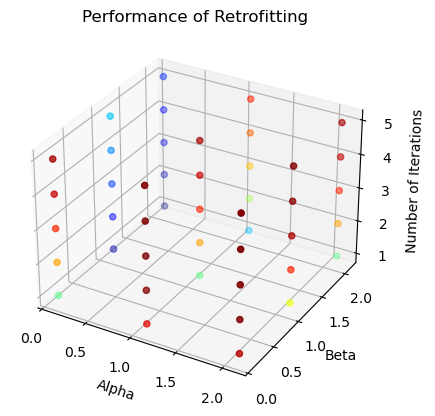

In [32]:
# Create a meshgrid for the hyperparameter values
FR_alpha_mesh, FR_beta_mesh, FR_nb_iter_mesh = np.meshgrid(FR_a_values, FR_b_values, FR_it_values)

# Plot the performances
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(FR_alpha_mesh, FR_beta_mesh, FR_nb_iter_mesh, c=FR_perf.flatten(), cmap='jet')
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Number of Iterations')
ax.set_title('Performance of Retrofitting')
plt.show()

In [33]:
# Retrofitting the original embeddings with the new (hyper)parameter values
FR_new_retrofitted_vec = retrofitting_wordVecs(FR_wordVecMat, FR_neighbors_matrix, FR_alpha, FR_beta, FR_nb_iter)
FR_new_retrofitted_dict = convert_matrix_to_dict(FR_new_retrofitted_vec, FR_wordList)
print_similarity_difference(FR_wordVecs, FR_new_retrofitted_dict, FR_lines, "fr")

Similarity between 'automobile' and 'sorcier' before retrofitting: 0.34021367774740296
Similarity between 'automobile' and 'sorcier' after retrofitting: 0.45847119721841395
Update: -0.11825751947101099

Similarity between 'monticule' and 'four' before retrofitting: 0.43879341293959623
Similarity between 'monticule' and 'four' after retrofitting: 0.39537919741980854
Update: 0.04341421551978769

Similarity between 'grimace' and 'instrument' before retrofitting: 0.14180289047896819
Similarity between 'grimace' and 'instrument' after retrofitting: 0.4521495132241185
Update: -0.31034662274515035

Similarity between 'refuge' and 'fruit' before retrofitting: 0.4690963805816724
Similarity between 'refuge' and 'fruit' after retrofitting: 0.6698434951712661
Update: -0.20074711458959366

Similarity between 'refuge' and 'moine' before retrofitting: 0.5552236480689976
Similarity between 'refuge' and 'moine' after retrofitting: 0.34871208862678305
Update: 0.20651155944221455

Similarity between 'cim

### 3.6 Testing the performances depending on the type of semantic relation

In [34]:
# Trying with antonyms
FR_neighbors_dict_an = get_wordnet_lexicon(FR_wordList, "antonyms")
# Generate the matrix of neighbor's embeddings
FR_neighbors_matrix_an = retrieve_neighbors_embedding_matrix(FR_wordVecMat, FR_wordList, FR_neighbors_dict_an)
# Retrofitting the English word embeddings
FR_retrofitted_vecs_an = retrofitting_wordVecs(FR_wordVecMat, FR_neighbors_matrix_an, FR_alpha, FR_beta, FR_nb_iter)
# Calculate the similarities between word embedding pairs after the retrofitting
FR_retrofitted_wordVecs_an = convert_matrix_to_dict(FR_retrofitted_vecs_an, FR_wordList)
FR_diff_an = get_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs_an, FR_lines, "fr")
print_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs_an, FR_lines, "fr")

In [35]:
# Trying with hyponyms
FR_neighbors_dict_hy = get_wordnet_lexicon(FR_wordList, "hyponyms") 
# Generate the matrix of neighbor's embeddings
FR_neighbors_matrix_hy  = retrieve_neighbors_embedding_matrix(FR_wordVecMat, FR_wordList, FR_neighbors_dict_hy )
# Retrofitting the English word embeddings
FR_retrofitted_vecs_hy  = retrofitting_wordVecs(FR_wordVecMat, FR_neighbors_matrix_hy , FR_alpha, FR_beta, FR_nb_iter)
# Calculate the similarities between word embedding pairs after the retrofitting
FR_retrofitted_wordVecs_hy  = convert_matrix_to_dict(FR_retrofitted_vecs_hy , FR_wordList)
FR_diff_hy = get_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs_hy, FR_lines, "fr")
print_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs_hy , FR_lines, "fr")

Similarity between 'automobile' and 'sorcier' before retrofitting: 0.34021367774740296
Similarity between 'automobile' and 'sorcier' after retrofitting: 0.5171482411614031
Update: -0.17693456341400016

Similarity between 'grimace' and 'instrument' before retrofitting: 0.14180289047896819
Similarity between 'grimace' and 'instrument' after retrofitting: 0.825299760687205
Update: -0.6834968702082368

Similarity between 'refuge' and 'fruit' before retrofitting: 0.4690963805816724
Similarity between 'refuge' and 'fruit' after retrofitting: 0.5301163490657612
Update: -0.061019968484088805

Similarity between 'refuge' and 'moine' before retrofitting: 0.5552236480689976
Similarity between 'refuge' and 'moine' after retrofitting: 0.2847921086918701
Update: 0.2704315393771275

Similarity between 'cimetière' and 'asylum' before retrofitting: 0.2047338546164688
Similarity between 'cimetière' and 'asylum' after retrofitting: 0.4750066702569277
Update: -0.2702728156404589

Similarity between 'refug

In [36]:
# Trying with hypernyms
FR_neighbors_dict_her = get_wordnet_lexicon(FR_wordList, "hypernyms") 
# Generate the matrix of neighbor's embeddings
FR_neighbors_matrix_her  = retrieve_neighbors_embedding_matrix(FR_wordVecMat, FR_wordList, FR_neighbors_dict_her )
# Retrofitting the English word embeddings
FR_retrofitted_vecs_her  = retrofitting_wordVecs(FR_wordVecMat, FR_neighbors_matrix_her, FR_alpha, FR_beta, FR_nb_iter)
# Calculate the similarities between word embedding pairs after the retrofitting
FR_retrofitted_wordVecs_her  = convert_matrix_to_dict(FR_retrofitted_vecs_her, FR_wordList)
FR_diff_her = get_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs_her, FR_lines, "fr")
print_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs_her, FR_lines, "fr")

Similarity between 'midi' and 'ficelle' before retrofitting: 0.19243910635976416
Similarity between 'midi' and 'ficelle' after retrofitting: 0.1166903606707673
Update: 0.07574874568899687

Similarity between 'fruit' and 'fournaise' before retrofitting: 0.2585502941803069
Similarity between 'fruit' and 'fournaise' after retrofitting: 0.04508684210669446
Update: 0.21346345207361245

Similarity between 'monticule' and 'four' before retrofitting: 0.43879341293959623
Similarity between 'monticule' and 'four' after retrofitting: 0.28167177800210325
Update: 0.15712163493749298

Similarity between 'grimace' and 'instrument' before retrofitting: 0.14180289047896819
Similarity between 'grimace' and 'instrument' after retrofitting: 0.24660291350835842
Update: -0.10480002302939023

Similarity between 'refuge' and 'fruit' before retrofitting: 0.4690963805816724
Similarity between 'refuge' and 'fruit' after retrofitting: 0.7452983952809606
Update: -0.27620201469928823

Similarity between 'refuge' an

In [37]:
# Trying with meronyms
FR_neighbors_dict_me = get_wordnet_lexicon(FR_wordList, "meronyms") 
# Generate the matrix of neighbor's embeddings
FR_neighbors_matrix_me  = retrieve_neighbors_embedding_matrix(FR_wordVecMat, FR_wordList, FR_neighbors_dict_me)
# Retrofitting the English word embeddings
FR_retrofitted_vecs_me  = retrofitting_wordVecs(FR_wordVecMat, FR_neighbors_matrix_me, FR_alpha, FR_beta, FR_nb_iter)
# Calculate the similarities between word embedding pairs after the retrofitting
FR_retrofitted_wordVecs_me  = convert_matrix_to_dict(FR_retrofitted_vecs_me, FR_wordList)
FR_diff_me = get_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs_me, FR_lines, "fr")
print_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs_me, FR_lines, "fr")

Similarity between 'automobile' and 'sorcier' before retrofitting: 0.34021367774740296
Similarity between 'automobile' and 'sorcier' after retrofitting: 0.43992426411259056
Update: -0.09971058636518759

Similarity between 'automobile' and 'coussin' before retrofitting: 0.24467684709945509
Similarity between 'automobile' and 'coussin' after retrofitting: 0.5466894647397313
Update: -0.30201261764027626

Similarity between 'auto' and 'voyage' before retrofitting: 0.20548656561958192
Similarity between 'auto' and 'voyage' after retrofitting: 0.356847241918008
Update: -0.15136067629842606

Similarity between 'automobile' and 'auto' before retrofitting: 0.5604866438763638
Similarity between 'automobile' and 'auto' after retrofitting: 0.9999999999999654
Update: -0.43951335612360154



In [38]:
# Trying with holonyms
FR_neighbors_dict_ho = get_wordnet_lexicon(FR_wordList, "holonyms") 
# Generate the matrix of neighbor's embeddings
FR_neighbors_matrix_ho  = retrieve_neighbors_embedding_matrix(FR_wordVecMat, FR_wordList, FR_neighbors_dict_ho)
# Retrofitting the English word embeddings
FR_retrofitted_vecs_ho  = retrofitting_wordVecs(FR_wordVecMat, FR_neighbors_matrix_ho, FR_alpha, FR_beta, FR_nb_iter)
# Calculate the similarities between word embedding pairs after the retrofitting
FR_retrofitted_wordVecs_ho  = convert_matrix_to_dict(FR_retrofitted_vecs_ho, FR_wordList)
FR_diff_ho = get_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs_ho, FR_lines, "fr")
print_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs_ho, FR_lines, "fr")

In [ ]:
# Trying with homonyms: NOT taken into account because it is too big
# FR_neighbors_dict_hom = get_wordnet_lexicon(FR_wordList, "homonyms") 
# # Generate the matrix of neighbor's embeddings
# FR_neighbors_matrix_hom  = retrieve_neighbors_embedding_matrix(FR_wordVecMat, FR_wordList, FR_neighbors_dict_hom)
# # Retrofitting the English word embeddings
# FR_retrofitted_vecs_hom  = retrofitting_wordVecs(FR_wordVecMat, FR_neighbors_matrix_hom, FR_alpha, FR_beta, FR_nb_iter)
# # Calculate the similarities between word embedding pairs after the retrofitting
# FR_retrofitted_wordVecs_hom  = convert_matrix_to_dict(FR_retrofitted_vecs_hom, FR_wordList)
# FR_diff_hom = get_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs_hom, FR_lines, "fr")
# print_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs_hom, FR_lines, "fr")

In [41]:
FR_relation_types_perf = {"synonyms": FR_diff_sy, "antonyms": FR_diff_an, "hyponyms": FR_diff_hy, "hypernyms": FR_diff_her, "meronyms": FR_diff_me, "holonyms": FR_diff_ho}
FR_correlation_scores = get_relation_type_spearman_score(FR_relation_types_perf)
print("Correlation Scores:")
for relation_type, correlation in FR_correlation_scores.items():
    print(f"{relation_type}: {correlation}")

Correlation Scores:
synonyms: 0.22413793103448273
antonyms: nan
hyponyms: -0.17272727272727273
hypernyms: 0.3834782608695652
meronyms: 0.7999999999999999
holonyms: nan


In [43]:
# Given the scores, only the synonyms will be taken into account for the update
# Since this has been computed already, there is no need for an update
# We just print the already updated vectors in the output file

# Print the updated embeddings in the output file to use for downstream tasks
print_word_vecs(FR_new_retrofitted_dict, FR_output_file)


Writing down the vectors in /Users/Iness/Library/CloudStorage/OneDrive-UniversitédeParis/Semestre 2/Projet TAL/Fichier FINAL/data/French/output_vectors/output_vectors.txt
